## File per il confronto tra autoencoder

Prova a copiare quello che viene fatto nel paper per quanto riguarda AE-NMF. Da testare ancora classico.


In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.model_selection import train_test_split
from functions import *
from models import AE_NMF


# set seed
np.random.seed(0)
torch.manual_seed(0)



In [17]:
# Load the .tsv file
data = pd.read_csv("data/GEL_data/catalogues_Ovary_SBS.tsv", sep="\t")

In [18]:
# We need to transpose the data because the colums contain the patient data and the rows contain the specifc mutations
train, test = train_test_split(data.T, test_size=0.2)


train = train.T
test = test.T

print(train.shape)
print(test.shape)


(96, 418)
(96, 105)


In [19]:
losses = []
errors = []
iterations = 1

for i in range(iterations):

    data = pd.read_csv("data/GEL_data/catalogues_Ovary_SBS.tsv", sep="\t")
    # We need to transpose the data because the colums contain the patient data and the rows contain the specifc mutations
    train, test = train_test_split(data.T, test_size=0.2, shuffle=True)


    train = train.T
    test = test.T

    print(train.shape)
    print(test.shape)

    autoencoder = AE_NMF.AE_NMF(input_dim = train.shape[1], latent_dim = 4, constraint= 'pg')

    model, loss, signature, exposures_mat, encoding_mat, iteration = AE_NMF.train(model = autoencoder,
                                                            training_data = train,
                                                            criterion = torch.nn.MSELoss(reduction = 'mean'),
                                                            optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4),
                                                            tol =  1e-10,
                                                            relative_tol=True,
                                                            max_iter = 10_000_000)


    data1 = signature@exposures_mat

    data = pd.DataFrame(data1, columns=train.columns)

    losses.append(loss[-1])


    diagonals_AE = signature.sum(axis = 0)
    exposures_AE = np.diag(diagonals_AE)@exposures_mat
    signatures_AE = (signature)@np.diag(1/diagonals_AE)

    out_error_AE = reconstruction_error(test, signatures_AE)
    errors.append(out_error_AE)


(96, 418)
(96, 105)


In [20]:
reconstruction_err = reconstruction_error(data = train, signature_matrix = signature)

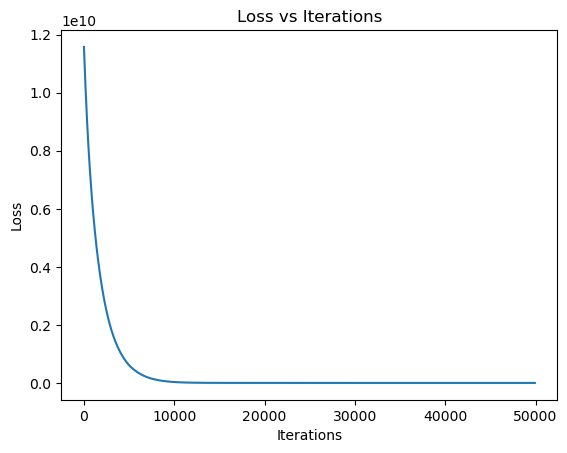

Last Loss:  14999.28515625


In [21]:
# plot the loss

plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()

print("Last Loss: ", loss[-1])

In [22]:

diagonals_AE = signature.sum(axis = 0)
exposures_AE = np.diag(diagonals_AE)@exposures_mat
signatures_AE = (signature)@np.diag(1/diagonals_AE)

out_error_AE = reconstruction_error(test, signatures_AE)

print(f"Error: {out_error_AE}")

Error: 11698.82161027849
